In [1]:
### National Snow and Ice Data Center Marginal Ice Zone Analysis

### National Snow and Ice Data Center Marginal Ice Zone Analysis

## Overview

The National Snow and Ice Data Center receives an operational Marginal Ice Zone (MIZ) product from the National Ice Center (USNIC) daily.  This project aims to compare the product generated by the USNIC with an automated passive microwave model.

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os

from modules.io import download_cdr_miz_range, download_nic_miz_range
from modules.compare import nic_file_to_grid, cdr_file_to_grid
from modules.display import create_basemap_plot, images_to_animation
import datetime
import numpy as np
import pandas as pd

In [3]:
# Start and end dates for analysis
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)

# Each grid cell in the cdr represents 25 km x 25 km
# TODO - derive this dynamically from the netcdf
grid_cell_area = 25 * 25

cdr_files = download_cdr_miz_range(start, end)#, verbose=True)
nic_files = download_nic_miz_range(start, end)#, verbose=True)

# For now in our analysis, let's just loop through cdf_files and nic_files zipped
# If the length isn't the same (or if they are out of order) then
# this should be a red flag that we aren't comparing the same dates
# TODO - instead of looping through zip(cdr_files, nic_files),
# loop through the desired date ranges and generate the file
# names for the dates

# At least we can perform this basic check
assert len(cdr_files) == len(nic_files)

In [4]:
def overlay_daily(cdr_file, nic_file, min_sic, max_sic, clobber_output=True):
    '''
    Overlay cdr and nic data onto a basemap plot that falls between the min_sic and max_sic, then save the resulting plot.
    Wraps plot_grid.
    '''
    print(f"Comparing {os.path.basename(cdr_file)} and {os.path.basename(nic_file)}", flush=True)
        
    # Load the files into memory as numpy arrays
    # This involves a rasterization of the nic grid which may be
    # memory-intensive
    cdr_grid, lats, lons, date_str = cdr_file_to_grid(cdr_file)
    output_name = os.path.join("data", 
                           "output", 
                           "day_comp", 
                           f"{int(100*min_sic):03}_to_{int(100*max_sic):03}", 
                           f"{date_str:%Y%m%d}_{int(100*min_sic):03}_to_{int(100*max_sic):03}.png")

    if os.path.isfile(output_name) and not clobber_output:
        # Output exists and we're not supposed to clobber it
        return

    nic_grid = nic_file_to_grid(nic_file)
    
    # First, mask both grids by the CDR flags - anything below zero
    # This will get a cell count with cells that are between the min and max
    cdr_grid = ((~cdr_grid.mask) & (cdr_grid > min_sic) & (cdr_grid <= max_sic))
    nic_grid = ((~cdr_grid.mask) & (nic_grid > min_sic) & (nic_grid <= max_sic))
    
    create_basemap_plot(lats, 
                        lons, 
                        cdr_grid, 
                        nic_grid, 
                        show=False,
                        save=output_name)
    del cdr_grid, lats, lons
    
    
def calculate_ice_area(cdr_file, nic_file, min_sic, max_sic):
    '''
    Calculate the area of ice between the provided min sea ice coverage and max sea ice coverage
    '''
    cdr_grid, lats, lons, date_str = cdr_file_to_grid(cdr_file)
    
    nic_grid = nic_file_to_grid(nic_file)
    
    # First, mask both grids by the CDR flags - anything below zero
    # This will get a cell count with cells that are between the min and max
    cdr_cell_count = ((~cdr_grid.mask) & (cdr_grid > min_sic) & (cdr_grid <= max_sic)).sum()
    nic_cell_count = ((~cdr_grid.mask) & (nic_grid > min_sic) & (nic_grid <= max_sic)).sum()
        
    cdr_area = cdr_cell_count * grid_cell_area
    nic_area = nic_cell_count * grid_cell_area
    
    print(f"Areas for {date_str}; {cdr_area}, {nic_area}")
    return cdr_area, nic_area, date_str

Comparing seaice_conc_daily_icdr_sh_f18_20190101_v01r00.nc and nic_miz2019001sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190102_v01r00.nc and nic_miz2019002sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190103_v01r00.nc and nic_miz2019003sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190104_v01r00.nc and nic_miz2019004sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190105_v01r00.nc and nic_miz2019005sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190106_v01r00.nc and nic_miz2019006sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190107_v01r00.nc and nic_miz2019007sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190108_v01r00.nc and nic_miz2019008sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190109_v01r00.nc and nic_miz2019009sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190110_v01r00.nc and nic_miz2019010sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190111_v01r00.nc and nic_miz2019011sc_pl_a.zip
Comparing seaice_conc

Comparing seaice_conc_daily_icdr_sh_f18_20190404_v01r00.nc and nic_miz2019094sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190405_v01r00.nc and nic_miz2019095sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190406_v01r00.nc and nic_miz2019096sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190407_v01r00.nc and nic_miz2019097sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190408_v01r00.nc and nic_miz2019098sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190409_v01r00.nc and nic_miz2019099sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190410_v01r00.nc and nic_miz2019100sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190411_v01r00.nc and nic_miz2019101sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190412_v01r00.nc and nic_miz2019102sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190413_v01r00.nc and nic_miz2019103sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190414_v01r00.nc and nic_miz2019104sc_pl_a.zip
Comparing seaice_conc

Comparing seaice_conc_daily_icdr_sh_f18_20190706_v01r00.nc and nic_miz2019187sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190707_v01r00.nc and nic_miz2019188sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190708_v01r00.nc and nic_miz2019189sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190709_v01r00.nc and nic_miz2019190sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190710_v01r00.nc and nic_miz2019191sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190711_v01r00.nc and nic_miz2019192sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190712_v01r00.nc and nic_miz2019193sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190713_v01r00.nc and nic_miz2019194sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190714_v01r00.nc and nic_miz2019195sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190715_v01r00.nc and nic_miz2019196sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20190716_v01r00.nc and nic_miz2019197sc_pl_a.zip
Comparing seaice_conc

Comparing seaice_conc_daily_icdr_sh_f18_20191007_v01r00.nc and nic_miz2019280sc_pl_a.zip
Comparing seaice_conc_daily_icdr_sh_f18_20191008_v01r00.nc and nic_miz2019281sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191009_v01r00.nc and nic_miz2019282sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191010_v01r00.nc and nic_miz2019283sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191011_v01r00.nc and nic_miz2019284sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191012_v01r00.nc and nic_miz2019285sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191013_v01r00.nc and nic_miz2019286sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191014_v01r00.nc and nic_miz2019287sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191015_v01r00.nc and nic_miz2019288sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191016_v01r00.nc and nic_miz2019289sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191017_v01r00.nc and nic_miz2019290sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191018_v01r00.nc and nic_miz2019291sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191019_v01r00.nc and nic_miz2019292sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191020_v01r00.nc and nic_miz2019293sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191021_v01r00.nc and nic_miz2019294sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191022_v01r00.nc and nic_miz2019295sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191023_v01r00.nc and nic_miz2019296sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191024_v01r00.nc and nic_miz2019297sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191025_v01r00.nc and nic_miz2019298sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191026_v01r00.nc and nic_miz2019299sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191027_v01r00.nc and nic_miz2019300sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191028_v01r00.nc and nic_miz2019301sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191029_v01r00.nc and nic_miz2019302sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191030_v01r00.nc and nic_miz2019303sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191031_v01r00.nc and nic_miz2019304sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191101_v01r00.nc and nic_miz2019305sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191102_v01r00.nc and nic_miz2019306sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191103_v01r00.nc and nic_miz2019307sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191104_v01r00.nc and nic_miz2019308sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191105_v01r00.nc and nic_miz2019309sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191106_v01r00.nc and nic_miz2019310sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191107_v01r00.nc and nic_miz2019311sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191108_v01r00.nc and nic_miz2019312sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191109_v01r00.nc and nic_miz2019313sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191110_v01r00.nc and nic_miz2019314sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191111_v01r00.nc and nic_miz2019315sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191112_v01r00.nc and nic_miz2019316sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191113_v01r00.nc and nic_miz2019317sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191114_v01r00.nc and nic_miz2019318sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191115_v01r00.nc and nic_miz2019319sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191116_v01r00.nc and nic_miz2019320sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191117_v01r00.nc and nic_miz2019321sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191118_v01r00.nc and nic_miz2019322sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191119_v01r00.nc and nic_miz2019323sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191120_v01r00.nc and nic_miz2019324sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191121_v01r00.nc and nic_miz2019325sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191122_v01r00.nc and nic_miz2019326sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191123_v01r00.nc and nic_miz2019327sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191124_v01r00.nc and nic_miz2019328sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191125_v01r00.nc and nic_miz2019329sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191126_v01r00.nc and nic_miz2019330sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191127_v01r00.nc and nic_miz2019331sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191128_v01r00.nc and nic_miz2019332sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191129_v01r00.nc and nic_miz2019333sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191130_v01r00.nc and nic_miz2019334sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191201_v01r00.nc and nic_miz2019335sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191202_v01r00.nc and nic_miz2019336sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191203_v01r00.nc and nic_miz2019337sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191204_v01r00.nc and nic_miz2019338sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191205_v01r00.nc and nic_miz2019339sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191206_v01r00.nc and nic_miz2019340sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191207_v01r00.nc and nic_miz2019341sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191208_v01r00.nc and nic_miz2019342sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191209_v01r00.nc and nic_miz2019343sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191210_v01r00.nc and nic_miz2019344sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191211_v01r00.nc and nic_miz2019345sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191212_v01r00.nc and nic_miz2019346sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191213_v01r00.nc and nic_miz2019347sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191214_v01r00.nc and nic_miz2019348sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191215_v01r00.nc and nic_miz2019349sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191216_v01r00.nc and nic_miz2019350sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191217_v01r00.nc and nic_miz2019351sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191218_v01r00.nc and nic_miz2019352sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191219_v01r00.nc and nic_miz2019353sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191220_v01r00.nc and nic_miz2019354sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191221_v01r00.nc and nic_miz2019355sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191222_v01r00.nc and nic_miz2019356sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191223_v01r00.nc and nic_miz2019357sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191224_v01r00.nc and nic_miz2019358sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191225_v01r00.nc and nic_miz2019359sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191226_v01r00.nc and nic_miz2019360sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191227_v01r00.nc and nic_miz2019361sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191228_v01r00.nc and nic_miz2019362sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191229_v01r00.nc and nic_miz2019363sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191230_v01r00.nc and nic_miz2019364sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20191231_v01r00.nc and nic_miz2019365sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Comparing seaice_conc_daily_icdr_sh_f18_20200101_v01r00.nc and nic_miz2020001sc_pl_a.zip


C:\Users\i24260\PycharmProjects\NSIDC-MIZ-Analysis\modules\display.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i', round=True


Areas for 2019-01-11 00:00:00; 3778750, 5669375
Areas for 2019-01-08 00:00:00; 4135000, 6648125
Areas for 2019-01-12 00:00:00; 3704375, 5639375
Areas for 2019-01-09 00:00:00; 4052500, 6371250
Areas for 2019-01-10 00:00:00; 3893750, 6090625
Areas for 2019-01-07 00:00:00; 4239375, 6775000
Areas for 2019-01-05 00:00:00; 4503750, 7100625
Areas for 2019-01-04 00:00:00; 4638750, 7303125
Areas for 2019-01-01 00:00:00; 5000000, 8433125
Areas for 2019-01-02 00:00:00; 4863125, 8279375
Areas for 2019-01-03 00:00:00; 4762500, 7765000
Areas for 2019-01-06 00:00:00; 4368125, 6877500
Areas for 2019-01-13 00:00:00; 3626875, 5449375
Areas for 2019-01-14 00:00:00; 3553125, 5352500
Areas for 2019-01-19 00:00:00; 3285625, 4727500
Areas for 2019-01-15 00:00:00; 3528750, 5126250
Areas for 2019-01-20 00:00:00; 3228125, 4493750
Areas for 2019-01-18 00:00:00; 3356875, 4726250
Areas for 2019-01-17 00:00:00; 3408125, 4798750
Areas for 2019-01-21 00:00:00; 3184375, 4526250
Areas for 2019-01-22 00:00:00; 3125000, 

Areas for 2019-06-20 00:00:00; 12934375, 13405625
Areas for 2019-06-21 00:00:00; 13076875, 13834375
Areas for 2019-06-22 00:00:00; 13166250, 13834375
Areas for 2019-06-23 00:00:00; 13256875, 13933125
Areas for 2019-06-24 00:00:00; 13414375, 13823125
Areas for 2019-06-25 00:00:00; 13655625, 14161250
Areas for 2019-06-26 00:00:00; 13773125, 14403750
Areas for 2019-06-27 00:00:00; 13864375, 14639375
Areas for 2019-06-28 00:00:00; 13949375, 14791250
Areas for 2019-06-29 00:00:00; 14032500, 14865000
Areas for 2019-06-30 00:00:00; 14085000, 14918750
Areas for 2019-07-01 00:00:00; 14160625, 15039375
Areas for 2019-07-02 00:00:00; 14275000, 15124375
Areas for 2019-07-03 00:00:00; 14376250, 15413125
Areas for 2019-07-05 00:00:00; 14601875, 15943750
Areas for 2019-07-04 00:00:00; 14474375, 15646250
Areas for 2019-07-06 00:00:00; 14761250, 15609375
Areas for 2019-07-07 00:00:00; 14825625, 15621250
Areas for 2019-07-08 00:00:00; 14973125, 15556250
Areas for 2019-07-09 00:00:00; 15101250, 16053125


Areas for 2019-12-01 00:00:00; 12829375, 15132500
Areas for 2019-12-03 00:00:00; 12309375, 14728750
Areas for 2019-12-02 00:00:00; 12560625, 14882500
Areas for 2019-12-04 00:00:00; 12122500, 14630625
Areas for 2019-12-07 00:00:00; 11391250, 13601875
Areas for 2019-12-08 00:00:00; 11076250, 13351250
Areas for 2019-12-05 00:00:00; 11829375, 14371250
Areas for 2019-12-06 00:00:00; 11586250, 14490625
Areas for 2019-12-09 00:00:00; 10772500, 13773750
Areas for 2019-12-10 00:00:00; 10465625, 13351875
Areas for 2019-12-12 00:00:00; 9877500, 13021875
Areas for 2019-12-11 00:00:00; 10167500, 13190000
Areas for 2019-12-13 00:00:00; 9599375, 12646875
Areas for 2019-12-14 00:00:00; 9383750, 13210625
Areas for 2019-12-15 00:00:00; 9191875, 12850000
Areas for 2019-12-16 00:00:00; 9061875, 12035000
Areas for 2019-12-18 00:00:00; 8602500, 11700625
Areas for 2019-12-17 00:00:00; 8851250, 11771250
Areas for 2019-12-19 00:00:00; 8256250, 11269375
Areas for 2019-12-20 00:00:00; 8011250, 10861250
Areas for

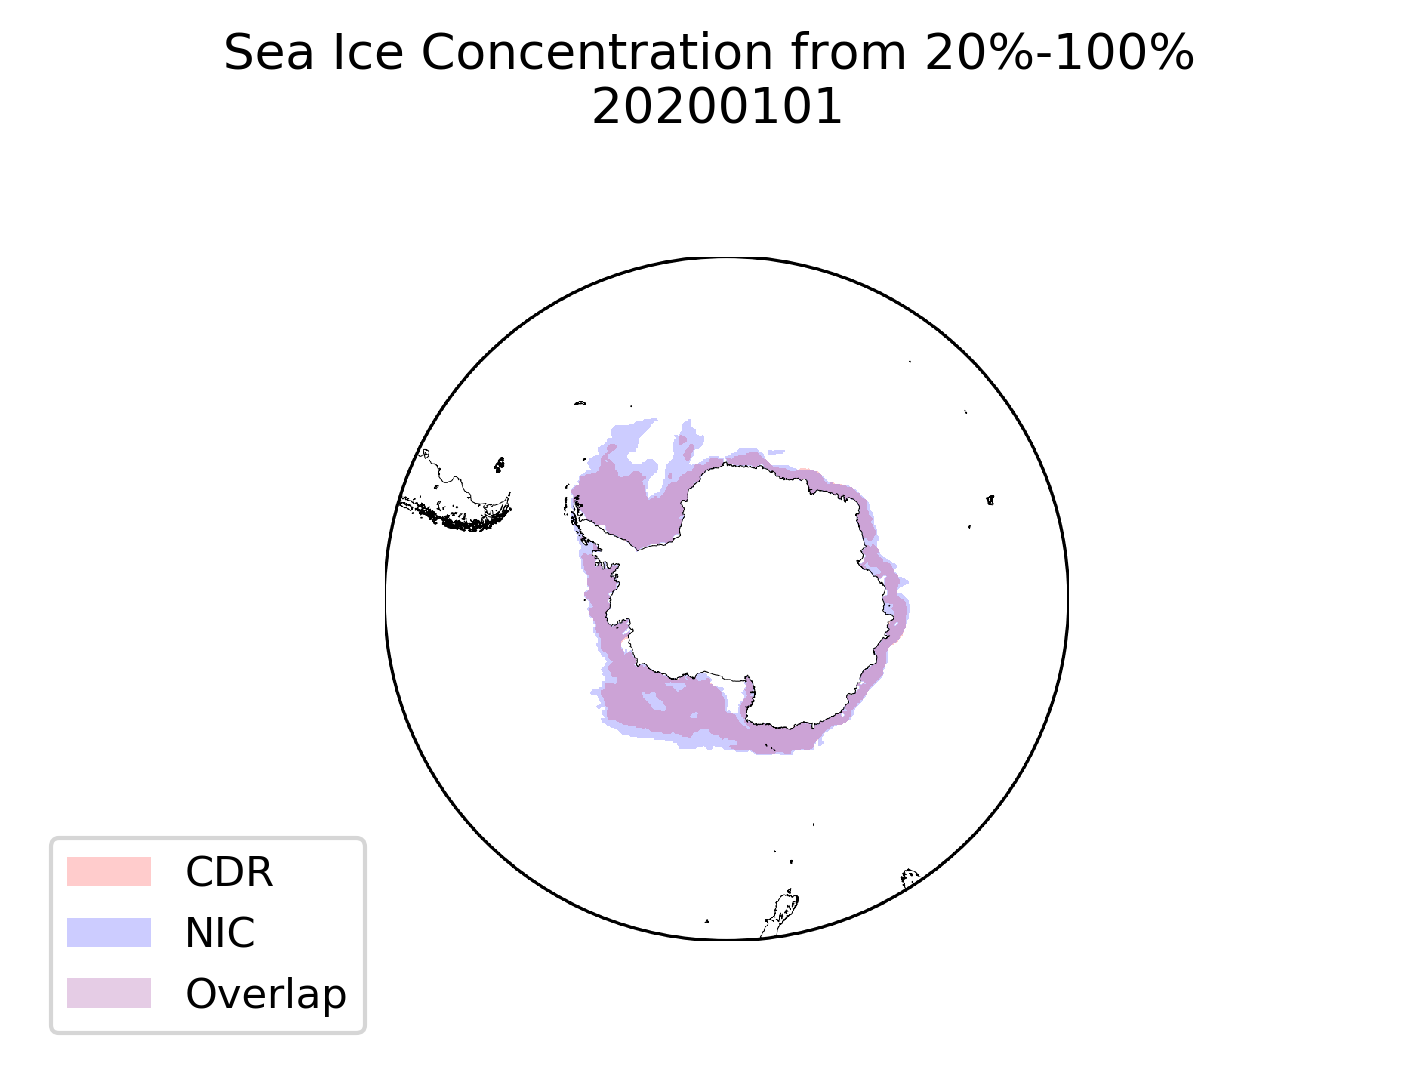

In [5]:
min_sic = 0.0
max_sic = 1.0

# Do not try threading/multiprocessing here.  I couldn't get it to work with matplotlib
for cdr_file, nic_file in zip(cdr_files, nic_files):
    overlay_daily(cdr_file, nic_file, min_sic, max_sic, clobber_output=False)

images_to_animation(os.path.join("data", "output", "day_comp", f"{int(100*min_sic):03}_to_{int(100*max_sic):03}"),
                    os.path.join("data", "output", f"daily_animation_{int(100*min_sic):03}_to_{int(100*max_sic):03}.mp4"))

ice_areas = Parallel(n_jobs=-1, backend='threading')(delayed(calculate_ice_area)
                                                     (cdr_file, nic_file, min_sic, max_sic) 
                                                     for cdr_file, nic_file in zip(cdr_files, nic_files))



          date  nic_data  cdr_data
0   2019-01-01   8433125   5000000
1   2019-01-02   8279375   4863125
2   2019-01-03   7765000   4762500
3   2019-01-04   7303125   4638750
4   2019-01-05   7100625   4503750
..         ...       ...       ...
361 2019-12-28   8903125   6556875
362 2019-12-29   8718125   6383125
363 2019-12-30   8446875   6236250
364 2019-12-31   8176875   6096875
365 2020-01-01   7996250   5985000

[366 rows x 3 columns]


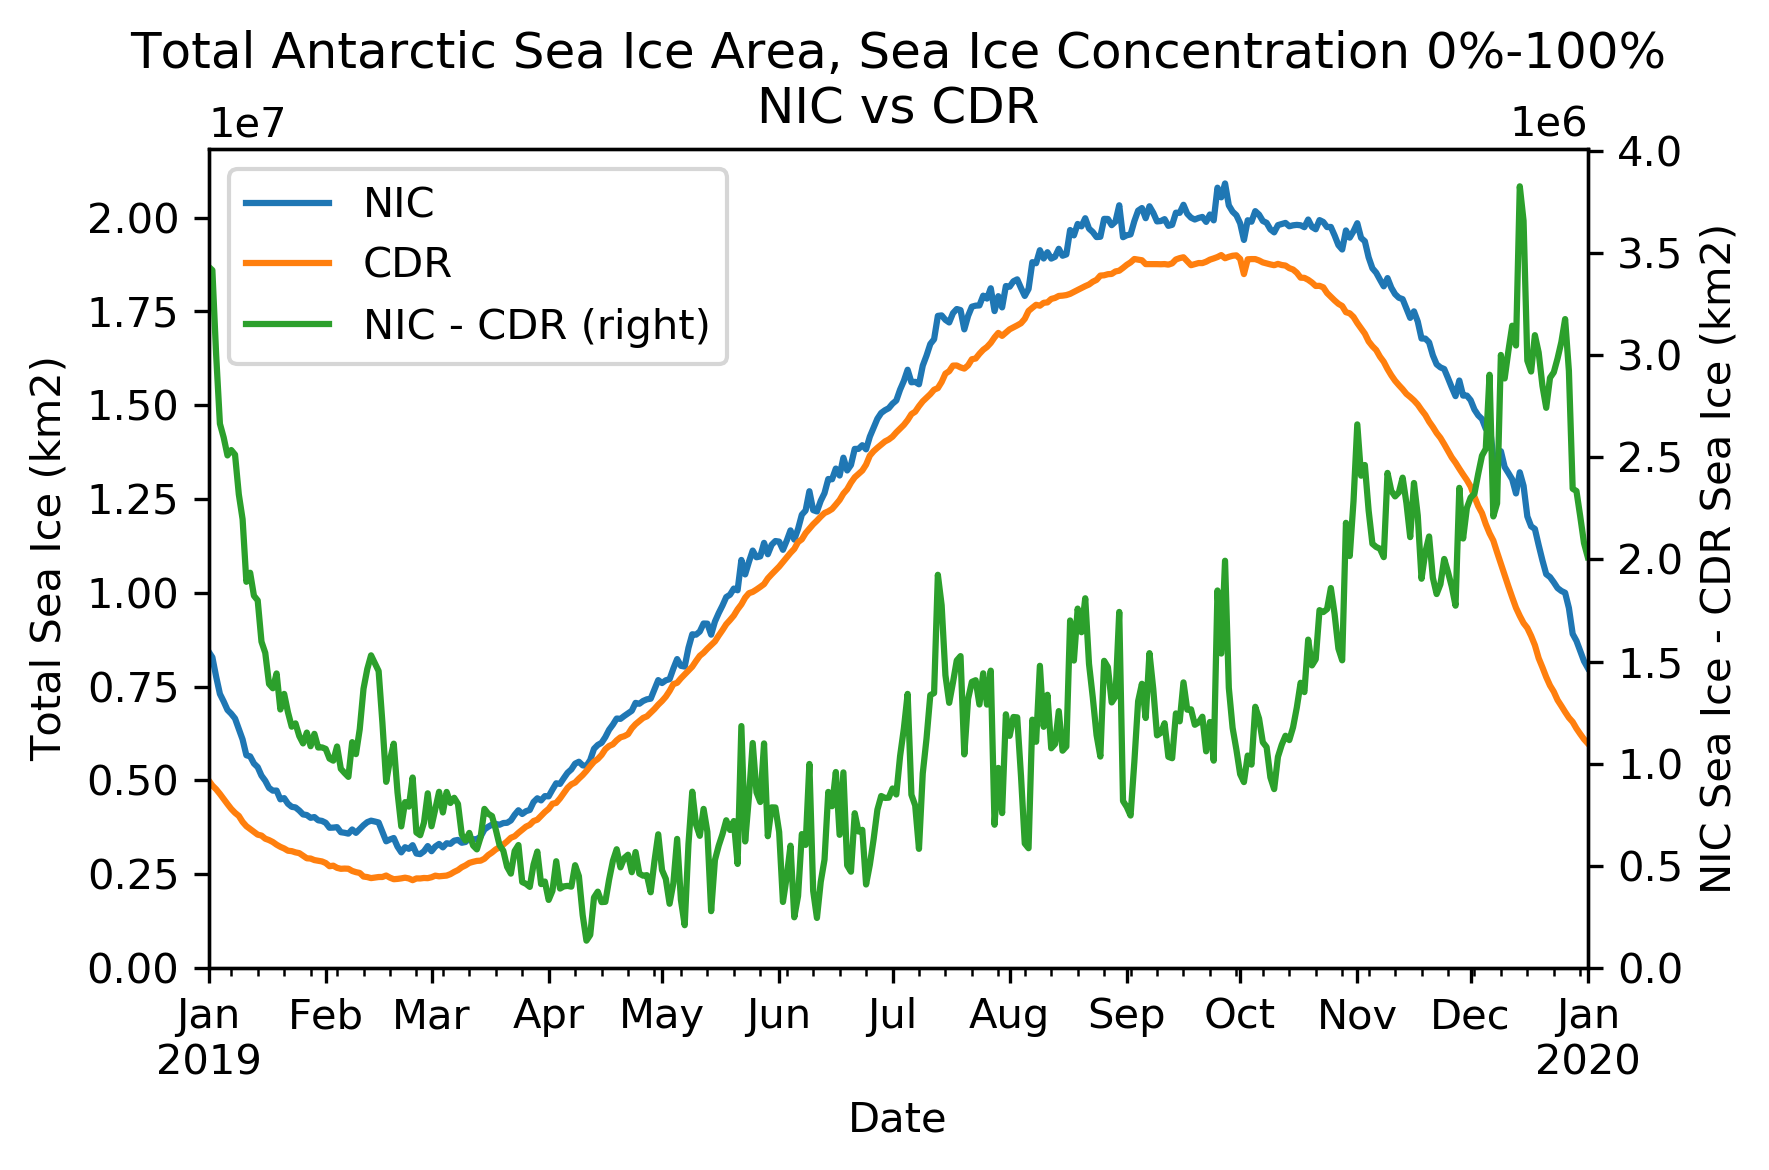

In [8]:
# TODO; return a dictionary instead of a tuple so unpacking is a bit easier to understand.
date = [i[2] for i in ice_areas]
nic_data = [i[1] for i in ice_areas]
cdr_data = [i[0] for i in ice_areas]

df = pd.DataFrame({"date": date, "nic_data": nic_data, "cdr_data": cdr_data})
print(df)
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)
df.columns = ['NIC', 'CDR']
df['NIC - CDR'] = df['NIC'] - df['CDR']

# Save if you've just made updates, load if you don't want to bother re-running
#df.to_csv("output.csv")
#df = pd.read_csv("output.csv")
#df.date = pd.to_datetime(df.date)
#df.set_index('date', inplace=True)

fig, ax = plt.subplots(dpi=300)
df['NIC'].plot(ax=ax, legend=True)
df['CDR'].plot(ax=ax, legend=True)
ax2 = df['NIC - CDR'].plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel("Total Sea Ice (km2)")
ax.set_xlabel("Date")
ax2.set_ylabel("NIC Sea Ice - CDR Sea Ice (km2)")
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,4))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,4))
ax.set_ylim(0)
ax2.set_ylim(0)

ax.set_title("Total Antarctic Sea Ice Area, Sea Ice Concentration 0%-100%\nNIC vs CDR")

plt.tight_layout()
plt.savefig(os.path.join("data", "output", "totals.png"))
plt.show()
